<a href="https://colab.research.google.com/github/nikhilnair31/SpectroTune---Genre-Classifier/blob/main/trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install sounddevice scipy

In [28]:
import time
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initializing

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
# Updated parameters
IMG_HEIGHT = 200
IMG_WIDTH = 150
IMG_CHANNELS = 3
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 30

# Paths
data_dir = "/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Data/spectrogram_images/genres_original"

## Data Loading

In [24]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

validation_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [31]:
# Create the dataset without any data augmentation or image transformation
full_dataset = datasets.ImageFolder(data_dir)

# Calculate the sizes of train/validation splits (80/20)
train_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - train_size

# Split the dataset into the train and validation sets
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])

In [32]:
# Apply the transformations only on the train dataset with dataset.map
train_dataset.dataset.transform = train_transform

# Apply the transformations only on the validation dataset with dataset.map
validation_dataset.dataset.transform = validation_transform

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## CNN

### Model Setup and Training

In [97]:
# Model architecture
class Net_Fancy(nn.Module):
    def __init__(self):
      super(Net_Fancy, self).__init__()

      # Input Shape: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]
      self.conv1 = nn.Conv2d(IMG_CHANNELS, 64, kernel_size=3, padding=1)
      self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.bn1 = nn.BatchNorm2d(64)

      self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
      self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.bn2 = nn.BatchNorm2d(32)

      self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
      self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.bn3 = nn.BatchNorm2d(32)

      # Calculate the flattened size by processing a dummy input through the convolution and pooling layers
      dummy_input = torch.zeros(1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
      dummy_output = self.bn3(self.maxpool3(self.conv3(self.bn2(self.maxpool2(self.conv2(self.bn1(self.maxpool1(self.conv1(dummy_input)))))))))
      self.flattened_size = dummy_output.view(-1).shape[0]

      self.fc1 = nn.Linear(self.flattened_size, 64)
      self.dropout1 = nn.Dropout(0.5)

      self.fc2 = nn.Linear(64, 32)
      self.dropout2 = nn.Dropout(0.5)

      self.fc3 = nn.Linear(32, 16)
      self.dropout3 = nn.Dropout(0.5)

      self.fc4 = nn.Linear(16, NUM_CLASSES) # Output layer with NUM_CLASSES nodes

    def forward(self, x):
      x = nn.functional.relu(self.bn1(self.maxpool1(self.conv1(x))))
      x = nn.functional.relu(self.bn2(self.maxpool2(self.conv2(x))))
      x = nn.functional.relu(self.bn3(self.maxpool3(self.conv3(x))))
      x = x.view(x.size(0), -1)  # Flatten the tensor
      x = nn.functional.relu(self.fc1(x))
      x = self.dropout1(x)
      x = nn.functional.relu(self.fc2(x))
      x = self.dropout2(x)
      x = nn.functional.relu(self.fc3(x))
      x = self.dropout3(x)
      x = self.fc4(x)  # No activation, as CrossEntropyLoss will apply softmax
      return x

In [98]:
class Net_Simple(nn.Module):
    def __init__(self):
        super(Net_Simple, self).__init__()
        self.conv1 = nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), 128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.bn2(x)

        x = self.flatten(x)

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)

        return x

In [99]:
class Net_Minimal(nn.Module):
    def __init__(self):
        super(Net_Minimal, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * (IMG_HEIGHT // 4) * (IMG_WIDTH // 4), NUM_CLASSES)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

### Model Training

In [100]:
# Create an instance of the model and move it to the GPU
model = Net_Simple().to(device)

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Before the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [101]:
# Train the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(validation_loader)
    val_accuracy = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch {str(epoch+1).zfill(2)}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Epoch Time: {epoch_time:.2f} seconds")

KeyboardInterrupt: ignored

In [ ]:
# Save the trained model
torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/simple_model.pth")

### Plots

In [ ]:
# Plots for training and validation losses
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="Validation")
plt.plot(train_losses, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plots for training and validation accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracies, label="Validation")
plt.plot(train_accuracies, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Results

In [ ]:
model = Net_Simple()

map_location = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/simple_model.pth", map_location=map_location))

model.to(device)
model.eval()

In [ ]:
# Initialize the lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict labels for validation dataset
with torch.no_grad():
    # Set model to evaluation mode
    model.eval()  # Do not forget this. It's important for certain layers like dropout and batchnorm.

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Access class_to_idx from the original dataset (full_dataset)
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# The class IDs in `true_labels` and `predicted_labels` need to be transformed to class names
predicted_class_names = [idx_to_class[label] for label in predicted_labels]
true_class_names = [idx_to_class[label] for label in true_labels]

# Generate the confusion matrix using class names
cm = confusion_matrix(true_class_names, predicted_class_names)

# Get list of class names from original dataset
class_names = [idx_to_class[idx] for idx in range(len(idx_to_class))]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get class names
class_names = full_dataset.classes

# Choose a random image from validation dataset
random_idx = random.randint(0, len(validation_dataset)-1)
input_img, actual_label = validation_dataset[random_idx]

# Add a batch dimension
input_img = input_img.unsqueeze(0)

# Move image to GPU
input_img = input_img.to(device)

# Make prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_img)
predicted_label = output.argmax(dim=1).item()

# Get the actual and predicted names
actual_name = class_names[actual_label]
predicted_name = class_names[predicted_label]

# Show the image

# Get mean and std
mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

# Denormalize image
input_img_denormalized = std * input_img[0].cpu().numpy() + mean

# Make sure values are in [0,1] range and transpose
input_img_denormalized = np.clip(input_img_denormalized, 0, 1)
input_img_denormalized = np.transpose(input_img_denormalized, (1, 2, 0))

plt.figure(figsize=(5, 4))
plt.axis('off')
plt.imshow(input_img_denormalized)
plt.title(f"Actual: {actual_name}, Predicted: {predicted_name}")
plt.show()


## Transfer Learning - MobileNetv2

### Setup

In [102]:
import torch
from torch import nn, optim
from torchvision import models
from tqdm import tqdm

### Model Training

In [103]:
# Load a pre-trained MobileNet model
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
num_features = model.classifier[1].in_features  # Get the input features of the classifier
model.classifier[1] = nn.Linear(num_features, NUM_CLASSES)  # Replace with a new linear layer with the number of classes

# If CUDA is available, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [104]:
# Define Loss and Optimizer
# We only want to update the parameters of the last layer, hence the optimizer only takes the parameters of the model.classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Finetune the model
model.train()

# Lists to keep track of performance metrics
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [105]:
# Loop over epochs
for epoch in range(EPOCHS):
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_corrects.double() / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            total_val += labels.size(0)

    val_loss = running_loss / len(validation_loader)
    val_accuracy = running_corrects.double() / total_val
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/30: 100%|██████████| 7/7 [00:06<00:00,  1.05batch/s]


Epoch 01/30 | Train Loss: 2.2231, Train Accuracy: 0.1819, Validation Loss: 2.3075, Validation Accuracy: 0.1250


Epoch 2/30: 100%|██████████| 7/7 [00:05<00:00,  1.36batch/s]


Epoch 02/30 | Train Loss: 1.8939, Train Accuracy: 0.3614, Validation Loss: 2.0677, Validation Accuracy: 0.3550


Epoch 3/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Epoch 03/30 | Train Loss: 1.6767, Train Accuracy: 0.4680, Validation Loss: 1.8326, Validation Accuracy: 0.3850


Epoch 4/30: 100%|██████████| 7/7 [00:05<00:00,  1.28batch/s]


Epoch 04/30 | Train Loss: 1.5162, Train Accuracy: 0.5257, Validation Loss: 1.6913, Validation Accuracy: 0.4400


Epoch 5/30: 100%|██████████| 7/7 [00:05<00:00,  1.19batch/s]


Epoch 05/30 | Train Loss: 1.4002, Train Accuracy: 0.5772, Validation Loss: 1.5983, Validation Accuracy: 0.4500


Epoch 6/30: 100%|██████████| 7/7 [00:05<00:00,  1.22batch/s]


Epoch 06/30 | Train Loss: 1.3641, Train Accuracy: 0.5822, Validation Loss: 1.5418, Validation Accuracy: 0.4700


Epoch 7/30: 100%|██████████| 7/7 [00:05<00:00,  1.33batch/s]


Epoch 07/30 | Train Loss: 1.2887, Train Accuracy: 0.6487, Validation Loss: 1.5230, Validation Accuracy: 0.5050


Epoch 8/30: 100%|██████████| 7/7 [00:06<00:00,  1.12batch/s]


Epoch 08/30 | Train Loss: 1.2267, Train Accuracy: 0.6412, Validation Loss: 1.4842, Validation Accuracy: 0.4700


Epoch 9/30: 100%|██████████| 7/7 [00:04<00:00,  1.40batch/s]


Epoch 09/30 | Train Loss: 1.1833, Train Accuracy: 0.6487, Validation Loss: 1.4476, Validation Accuracy: 0.5100


Epoch 10/30: 100%|██████████| 7/7 [00:06<00:00,  1.05batch/s]


Epoch 10/30 | Train Loss: 1.1118, Train Accuracy: 0.6926, Validation Loss: 1.4415, Validation Accuracy: 0.5100


Epoch 11/30: 100%|██████████| 7/7 [00:04<00:00,  1.40batch/s]


Epoch 11/30 | Train Loss: 1.0981, Train Accuracy: 0.6738, Validation Loss: 1.4163, Validation Accuracy: 0.4750


Epoch 12/30: 100%|██████████| 7/7 [00:06<00:00,  1.02batch/s]


Epoch 12/30 | Train Loss: 1.0488, Train Accuracy: 0.6801, Validation Loss: 1.3954, Validation Accuracy: 0.5150


Epoch 13/30: 100%|██████████| 7/7 [00:04<00:00,  1.40batch/s]


Epoch 13/30 | Train Loss: 1.0073, Train Accuracy: 0.6801, Validation Loss: 1.4062, Validation Accuracy: 0.4950


Epoch 14/30: 100%|██████████| 7/7 [00:07<00:00,  1.02s/batch]


Epoch 14/30 | Train Loss: 0.9895, Train Accuracy: 0.6939, Validation Loss: 1.3681, Validation Accuracy: 0.5200


Epoch 15/30: 100%|██████████| 7/7 [00:04<00:00,  1.41batch/s]


Epoch 15/30 | Train Loss: 0.9397, Train Accuracy: 0.7353, Validation Loss: 1.3724, Validation Accuracy: 0.5200


Epoch 16/30: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch]


Epoch 16/30 | Train Loss: 0.9381, Train Accuracy: 0.7102, Validation Loss: 1.3653, Validation Accuracy: 0.5050


Epoch 17/30: 100%|██████████| 7/7 [00:05<00:00,  1.40batch/s]


Epoch 17/30 | Train Loss: 0.9164, Train Accuracy: 0.7315, Validation Loss: 1.3695, Validation Accuracy: 0.5150


Epoch 18/30: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch]


Epoch 18/30 | Train Loss: 0.8796, Train Accuracy: 0.7528, Validation Loss: 1.3762, Validation Accuracy: 0.4900


Epoch 19/30: 100%|██████████| 7/7 [00:05<00:00,  1.36batch/s]


Epoch 19/30 | Train Loss: 0.9109, Train Accuracy: 0.7491, Validation Loss: 1.3481, Validation Accuracy: 0.4750


Epoch 20/30: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch]


Epoch 20/30 | Train Loss: 0.8615, Train Accuracy: 0.7390, Validation Loss: 1.3656, Validation Accuracy: 0.4950


Epoch 21/30: 100%|██████████| 7/7 [00:05<00:00,  1.40batch/s]


Epoch 21/30 | Train Loss: 0.8682, Train Accuracy: 0.7779, Validation Loss: 1.3739, Validation Accuracy: 0.5000


Epoch 22/30: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch]


Epoch 22/30 | Train Loss: 0.8137, Train Accuracy: 0.7616, Validation Loss: 1.3391, Validation Accuracy: 0.5050


Epoch 23/30: 100%|██████████| 7/7 [00:05<00:00,  1.39batch/s]


Epoch 23/30 | Train Loss: 0.8110, Train Accuracy: 0.7666, Validation Loss: 1.3599, Validation Accuracy: 0.5050


Epoch 24/30: 100%|██████████| 7/7 [00:07<00:00,  1.11s/batch]


Epoch 24/30 | Train Loss: 0.8292, Train Accuracy: 0.7679, Validation Loss: 1.3417, Validation Accuracy: 0.5200


Epoch 25/30: 100%|██████████| 7/7 [00:05<00:00,  1.36batch/s]


Epoch 25/30 | Train Loss: 0.7990, Train Accuracy: 0.7854, Validation Loss: 1.3568, Validation Accuracy: 0.5050


Epoch 26/30: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch]


Epoch 26/30 | Train Loss: 0.7562, Train Accuracy: 0.7779, Validation Loss: 1.3692, Validation Accuracy: 0.5050


Epoch 27/30: 100%|██████████| 7/7 [00:05<00:00,  1.38batch/s]


Epoch 27/30 | Train Loss: 0.7591, Train Accuracy: 0.7942, Validation Loss: 1.3301, Validation Accuracy: 0.4800


Epoch 28/30: 100%|██████████| 7/7 [00:07<00:00,  1.06s/batch]


Epoch 28/30 | Train Loss: 0.7223, Train Accuracy: 0.7842, Validation Loss: 1.3371, Validation Accuracy: 0.4750


Epoch 29/30: 100%|██████████| 7/7 [00:05<00:00,  1.38batch/s]


Epoch 29/30 | Train Loss: 0.7181, Train Accuracy: 0.7942, Validation Loss: 1.3180, Validation Accuracy: 0.4850


Epoch 30/30: 100%|██████████| 7/7 [00:10<00:00,  1.44s/batch]


Epoch 30/30 | Train Loss: 0.7088, Train Accuracy: 0.8193, Validation Loss: 1.3349, Validation Accuracy: 0.4950


In [106]:
# Save the trained model
torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/mobilenet_model.pth")

### Plots

In [109]:
# Ensure all tensors are moved to CPU and detached if necessary
train_losses = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in train_losses]
validation_losses = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in validation_losses]
train_accuracies = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in train_accuracies]
validation_accuracies = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in validation_accuracies]

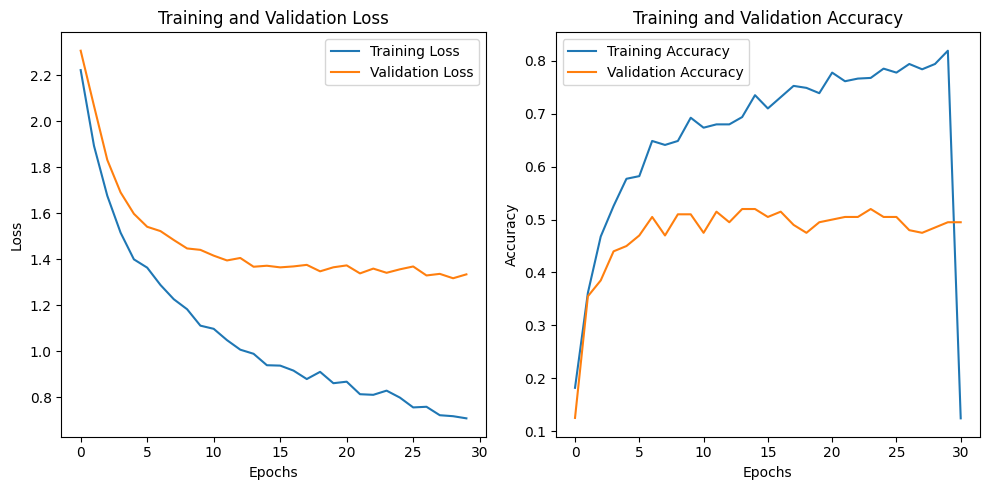

In [111]:
# Plot training and validation loss
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')  # Convert tensors to floats
plt.plot(validation_accuracies, label='Validation Accuracy')  # Convert tensors to floats
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Results

In [112]:
model = models.mobilenet_v2(pretrained=False)

num_features = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_features, NUM_CLASSES)

model_path = r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/mobilenet_model.pth"
model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

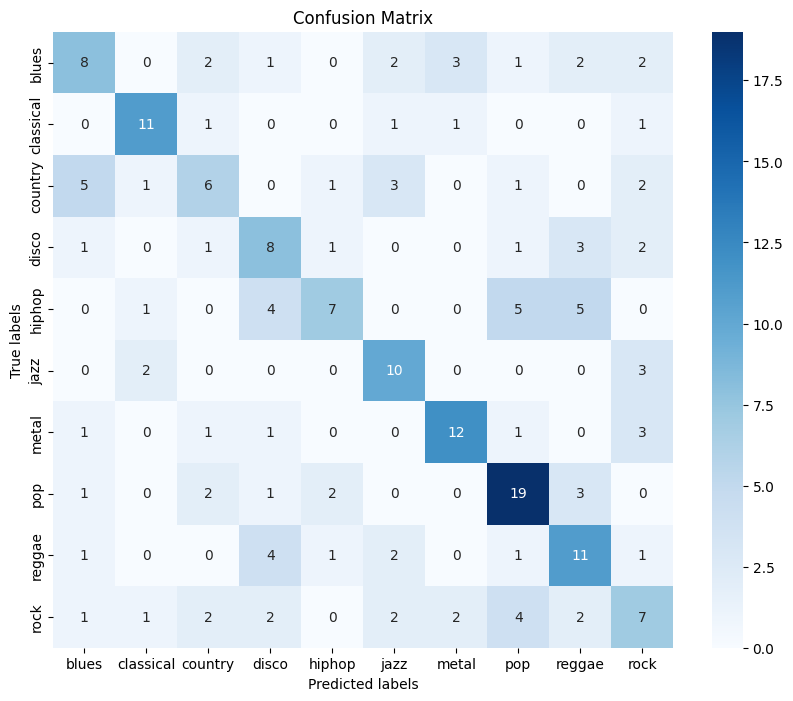

In [113]:
# Initialize the lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict labels for validation dataset
with torch.no_grad():
    # Set model to evaluation mode
    model.eval()  # Do not forget this. It's important for certain layers like dropout and batchnorm.

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Access class_to_idx from the original dataset (full_dataset)
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# The class IDs in `true_labels` and `predicted_labels` need to be transformed to class names
predicted_class_names = [idx_to_class[label] for label in predicted_labels]
true_class_names = [idx_to_class[label] for label in true_labels]

# Generate the confusion matrix using class names
cm = confusion_matrix(true_class_names, predicted_class_names)

# Get list of class names from original dataset
class_names = [idx_to_class[idx] for idx in range(len(idx_to_class))]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

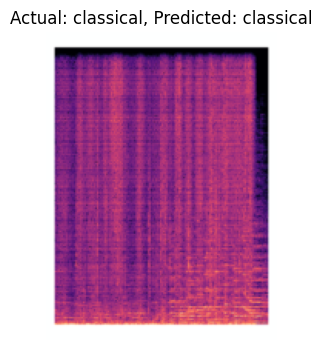

In [114]:
# Get class names
class_names = full_dataset.classes

# Choose a random image from validation dataset
random_idx = random.randint(0, len(validation_dataset)-1)
input_img, actual_label = validation_dataset[random_idx]

# Add a batch dimension
input_img = input_img.unsqueeze(0)

# Move image to GPU
input_img = input_img.to(device)

# Make prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_img)
predicted_label = output.argmax(dim=1).item()

# Get the actual and predicted names
actual_name = class_names[actual_label]
predicted_name = class_names[predicted_label]

# Show the image

# Get mean and std
mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

# Denormalize image
input_img_denormalized = std * input_img[0].cpu().numpy() + mean

# Make sure values are in [0,1] range and transpose
input_img_denormalized = np.clip(input_img_denormalized, 0, 1)
input_img_denormalized = np.transpose(input_img_denormalized, (1, 2, 0))

plt.figure(figsize=(5, 4))
plt.axis('off')
plt.imshow(input_img_denormalized)
plt.title(f"Actual: {actual_name}, Predicted: {predicted_name}")
plt.show()


## Transfer Learning - VGG16

### Setup

In [115]:
import torch
from torch import nn, optim
from torchvision import models
from tqdm import tqdm

### Model Training

In [116]:
# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze the feature parameters to avoid updating them during training
for param in model.features.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new layer that matches the number of classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [117]:
# Define Loss and Optimizer
# We only want to update the parameters of the last layer, hence the optimizer only takes the parameters of the model.classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Finetune the model
model.train()

# Lists to keep track of performance metrics
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [118]:
# Loop over epochs
for epoch in range(EPOCHS):
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    # Training loop
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_corrects.double() / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            total_val += labels.size(0)

    val_loss = running_loss / len(validation_loader)
    val_accuracy = running_corrects.double() / total_val
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/30: 100%|██████████| 7/7 [00:07<00:00,  1.07s/batch]


Train Loss: 2.3561, Train Accuracy: 0.1895, Validation Loss: 1.9271, Validation Accuracy: 0.3300


Epoch 2/30: 100%|██████████| 7/7 [00:07<00:00,  1.09s/batch]


Train Loss: 2.0548, Train Accuracy: 0.2610, Validation Loss: 2.0583, Validation Accuracy: 0.3100


Epoch 3/30: 100%|██████████| 7/7 [00:07<00:00,  1.12s/batch]


Train Loss: 1.8740, Train Accuracy: 0.3237, Validation Loss: 1.6722, Validation Accuracy: 0.3700


Epoch 4/30: 100%|██████████| 7/7 [00:07<00:00,  1.00s/batch]


Train Loss: 1.6084, Train Accuracy: 0.4166, Validation Loss: 1.5215, Validation Accuracy: 0.4300


Epoch 5/30: 100%|██████████| 7/7 [00:06<00:00,  1.08batch/s]


Train Loss: 1.5201, Train Accuracy: 0.4429, Validation Loss: 1.4810, Validation Accuracy: 0.4650


Epoch 6/30: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch]


Train Loss: 1.3575, Train Accuracy: 0.4868, Validation Loss: 1.4703, Validation Accuracy: 0.4700


Epoch 7/30: 100%|██████████| 7/7 [00:06<00:00,  1.15batch/s]


Train Loss: 1.3961, Train Accuracy: 0.4981, Validation Loss: 1.4683, Validation Accuracy: 0.4500


Epoch 8/30: 100%|██████████| 7/7 [00:08<00:00,  1.24s/batch]


Train Loss: 1.2884, Train Accuracy: 0.5232, Validation Loss: 1.2767, Validation Accuracy: 0.5500


Epoch 9/30: 100%|██████████| 7/7 [00:06<00:00,  1.13batch/s]


Train Loss: 1.1821, Train Accuracy: 0.5445, Validation Loss: 1.3141, Validation Accuracy: 0.5000


Epoch 10/30: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch]


Train Loss: 1.1438, Train Accuracy: 0.5997, Validation Loss: 1.2149, Validation Accuracy: 0.5650


Epoch 11/30: 100%|██████████| 7/7 [00:07<00:00,  1.03s/batch]


Train Loss: 0.9802, Train Accuracy: 0.6386, Validation Loss: 1.3503, Validation Accuracy: 0.5350


Epoch 12/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Train Loss: 0.9766, Train Accuracy: 0.6186, Validation Loss: 1.3959, Validation Accuracy: 0.5350


Epoch 13/30: 100%|██████████| 7/7 [00:08<00:00,  1.17s/batch]


Train Loss: 0.8956, Train Accuracy: 0.6888, Validation Loss: 1.3494, Validation Accuracy: 0.5500


Epoch 14/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Train Loss: 0.9067, Train Accuracy: 0.6826, Validation Loss: 1.2585, Validation Accuracy: 0.5750


Epoch 15/30: 100%|██████████| 7/7 [00:08<00:00,  1.21s/batch]


Train Loss: 0.8374, Train Accuracy: 0.7014, Validation Loss: 1.3712, Validation Accuracy: 0.5500


Epoch 16/30: 100%|██████████| 7/7 [00:06<00:00,  1.12batch/s]


Train Loss: 0.8664, Train Accuracy: 0.6888, Validation Loss: 1.4091, Validation Accuracy: 0.5150


Epoch 17/30: 100%|██████████| 7/7 [00:07<00:00,  1.01s/batch]


Train Loss: 0.8361, Train Accuracy: 0.6750, Validation Loss: 1.3448, Validation Accuracy: 0.5250


Epoch 18/30: 100%|██████████| 7/7 [00:07<00:00,  1.04s/batch]


Train Loss: 0.6807, Train Accuracy: 0.7654, Validation Loss: 1.1518, Validation Accuracy: 0.5900


Epoch 19/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Train Loss: 0.6581, Train Accuracy: 0.7666, Validation Loss: 1.2135, Validation Accuracy: 0.5650


Epoch 20/30: 100%|██████████| 7/7 [00:08<00:00,  1.27s/batch]


Train Loss: 0.7537, Train Accuracy: 0.7453, Validation Loss: 1.2360, Validation Accuracy: 0.5750


Epoch 21/30: 100%|██████████| 7/7 [00:06<00:00,  1.16batch/s]


Train Loss: 0.6104, Train Accuracy: 0.7842, Validation Loss: 1.2520, Validation Accuracy: 0.5650


Epoch 22/30: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch]


Train Loss: 0.6577, Train Accuracy: 0.7729, Validation Loss: 1.3295, Validation Accuracy: 0.5600


Epoch 23/30: 100%|██████████| 7/7 [00:07<00:00,  1.01s/batch]


Train Loss: 0.5944, Train Accuracy: 0.7767, Validation Loss: 1.4205, Validation Accuracy: 0.5700


Epoch 24/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Train Loss: 0.6552, Train Accuracy: 0.7804, Validation Loss: 1.3402, Validation Accuracy: 0.5450


Epoch 25/30: 100%|██████████| 7/7 [00:08<00:00,  1.15s/batch]


Train Loss: 0.5795, Train Accuracy: 0.8030, Validation Loss: 1.3578, Validation Accuracy: 0.5750


Epoch 26/30: 100%|██████████| 7/7 [00:06<00:00,  1.14batch/s]


Train Loss: 0.5513, Train Accuracy: 0.8181, Validation Loss: 1.4703, Validation Accuracy: 0.5600


Epoch 27/30: 100%|██████████| 7/7 [00:08<00:00,  1.24s/batch]


Train Loss: 0.5235, Train Accuracy: 0.8143, Validation Loss: 1.4113, Validation Accuracy: 0.5350


Epoch 28/30: 100%|██████████| 7/7 [00:06<00:00,  1.11batch/s]


Train Loss: 0.4821, Train Accuracy: 0.8281, Validation Loss: 1.4447, Validation Accuracy: 0.6100


Epoch 29/30: 100%|██████████| 7/7 [00:07<00:00,  1.05s/batch]


Train Loss: 0.5821, Train Accuracy: 0.8105, Validation Loss: 1.3341, Validation Accuracy: 0.5900


Epoch 30/30: 100%|██████████| 7/7 [00:07<00:00,  1.08s/batch]


Train Loss: 0.4670, Train Accuracy: 0.8294, Validation Loss: 1.3869, Validation Accuracy: 0.5850


In [119]:
# Save the trained model
torch.save(model.state_dict(), r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/vgg16_model.pth")

### Plots

In [125]:
# Ensure all tensors are moved to CPU and detached if necessary
train_losses = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in train_losses]
validation_losses = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in validation_losses]
train_accuracies = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in train_accuracies]
validation_accuracies = [x.cpu().detach() if isinstance(x, torch.Tensor) else x for x in validation_accuracies]

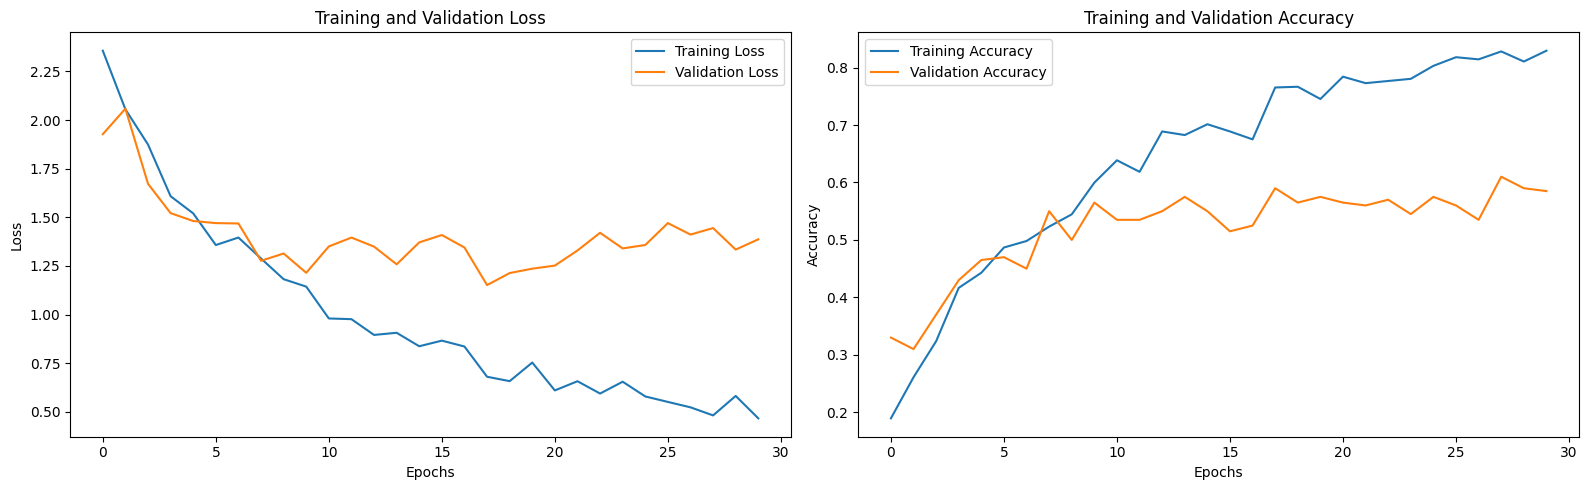

In [126]:
# Plot training and validation loss
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')  # Convert tensors to floats
plt.plot(validation_accuracies, label='Validation Accuracy')  # Convert tensors to floats
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Results

In [127]:
model = models.vgg16(pretrained=False)

num_features = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_features, NUM_CLASSES)

model.load_state_dict(torch.load(r"/content/drive/MyDrive/Colab Notebooks/2. Fall/AML/Model/vgg16_model.pth"))

model.eval()

# If using a GPU, move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


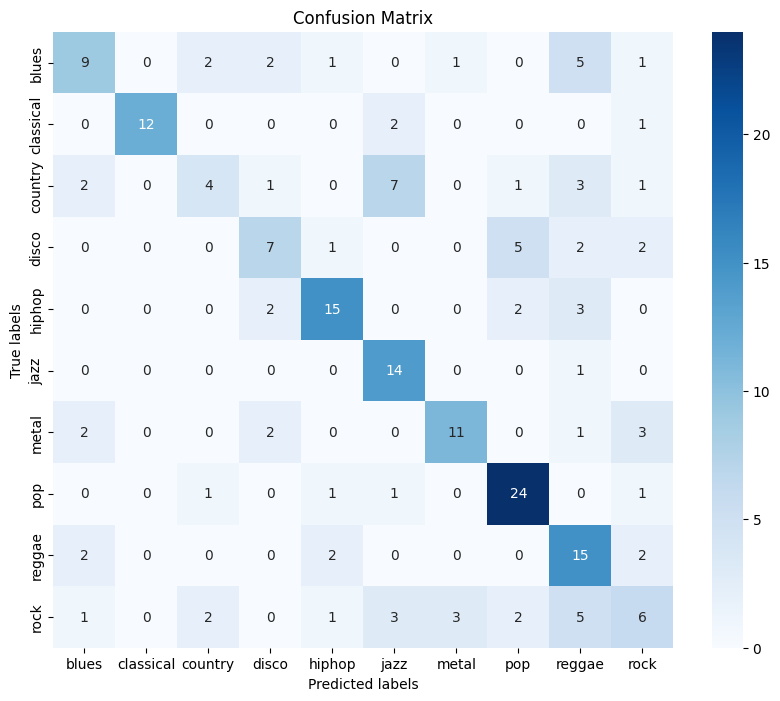

In [128]:
# Initialize the lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict labels for validation dataset
with torch.no_grad():
    # Set model to evaluation mode
    model.eval()  # Do not forget this. It's important for certain layers like dropout and batchnorm.

    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())

# Access class_to_idx from the original dataset (full_dataset)
class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# The class IDs in `true_labels` and `predicted_labels` need to be transformed to class names
predicted_class_names = [idx_to_class[label] for label in predicted_labels]
true_class_names = [idx_to_class[label] for label in true_labels]

# Generate the confusion matrix using class names
cm = confusion_matrix(true_class_names, predicted_class_names)

# Get list of class names from original dataset
class_names = [idx_to_class[idx] for idx in range(len(idx_to_class))]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

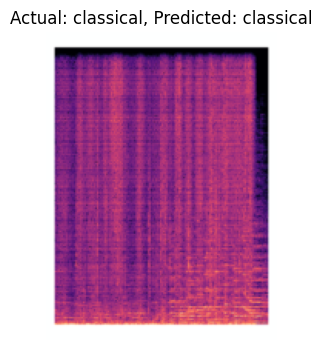

In [129]:
# Get class names
class_names = full_dataset.classes

# Choose a random image from validation dataset
random_idx = random.randint(0, len(validation_dataset)-1)
input_img, actual_label = validation_dataset[random_idx]

# Add a batch dimension
input_img = input_img.unsqueeze(0)

# Move image to GPU
input_img = input_img.to(device)

# Make prediction
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(input_img)
predicted_label = output.argmax(dim=1).item()

# Get the actual and predicted names
actual_name = class_names[actual_label]
predicted_name = class_names[predicted_label]

# Show the image

# Get mean and std
mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)

# Denormalize image
input_img_denormalized = std * input_img[0].cpu().numpy() + mean

# Make sure values are in [0,1] range and transpose
input_img_denormalized = np.clip(input_img_denormalized, 0, 1)
input_img_denormalized = np.transpose(input_img_denormalized, (1, 2, 0))

plt.figure(figsize=(5, 4))
plt.axis('off')
plt.imshow(input_img_denormalized)
plt.title(f"Actual: {actual_name}, Predicted: {predicted_name}")
plt.show()
